In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision import models
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
# import cv2

In [122]:
print(torch.__version__)
print(torchvision.__version__)

1.9.0+cu111
0.10.0+cu111


In [123]:
train_data_path = "../data/train/"
test_data_path = "../data/test/"

In [124]:
transforms = {"train":transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.CenterCrop(64),
    #transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])]),
    "test":transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])
])}

In [125]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms["train"])
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms["test"])

In [139]:
train_data.imgs[-10:]

[('../data/train/White\\24620615.jpg', 15),
 ('../data/train/White\\24620616.jpg', 15),
 ('../data/train/White\\24622330.jpg', 15),
 ('../data/train/White\\24622331.jpg', 15),
 ('../data/train/White\\24622332.jpg', 15),
 ('../data/train/White\\24622333.jpg', 15),
 ('../data/train/White\\24622334.jpg', 15),
 ('../data/train/White\\24622335.jpg', 15),
 ('../data/train/White\\24622336.jpg', 15),
 ('../data/train/White\\24622337.jpg', 15)]

In [126]:
print("Num Images in Train Dataset:", len(train_data))
print("Num Images in Test Dataset:", len(test_data))

Num Images in Train Dataset: 3416
Num Images in Test Dataset: 373


In [127]:
batch_size=16
train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size,num_workers=8)

In [128]:
len(train_data)

3416

In [129]:
len(train_data.targets)

3416

In [130]:
batch = next(iter(train_data_loader))

In [131]:
images, labels = batch

In [132]:
images.shape

torch.Size([16, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([ 8, 14, 14,  2,  2, 14,  2, 15,  2, 13, 14, 14,  5, 15,  2,  2])


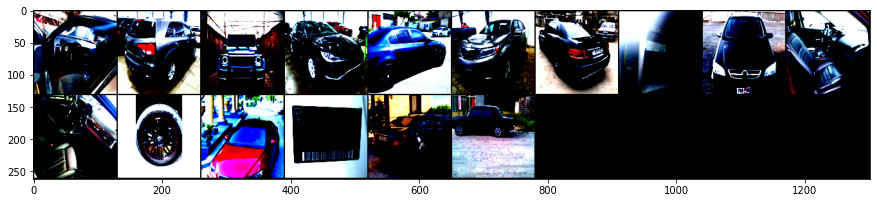

In [135]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels:", labels)

In [137]:
grid.shape

torch.Size([3, 262, 1302])

In [70]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*29*29, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=16)
#         self.act3 = nn.Softmax(dim=1)
    def forward(self, x):
        # (1) input layer
        x = x
        
        # (2) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        x = x.reshape(-1, 12*29*29)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        x = self.fc3(x)
#         x = F.softmax(x,dim=1)
        return x
network = Net()

In [71]:
sample = next(iter(train_data))

In [72]:
image,label = sample
print(label)
image.shape

0


torch.Size([3, 128, 128])

In [73]:
image.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [74]:
pred = network(image.unsqueeze(0))

In [75]:
pred.shape

torch.Size([1, 16])

In [76]:
pred.argmax(dim=1)

tensor([0])

In [77]:
batch = next(iter(train_data_loader))

In [78]:
images,labels = batch

**Calculating the loss**

In [79]:
preds = network(images)

In [80]:
loss = F.cross_entropy(preds,labels)
loss.item()

2.7751667499542236

**Calculating gradients**

In [81]:
print(network.conv1.weight)

Parameter containing:
tensor([[[[ 0.0008,  0.1055, -0.1129, -0.0796, -0.0418],
          [ 0.0261,  0.0786, -0.0015, -0.0263,  0.0167],
          [ 0.0826, -0.0586, -0.1054,  0.0975, -0.0403],
          [-0.0470, -0.0934, -0.0095,  0.0206,  0.0772],
          [-0.0016,  0.0833, -0.0864, -0.1018, -0.0194]],

         [[ 0.1000, -0.0689,  0.0582,  0.0062, -0.0812],
          [-0.0146, -0.0379,  0.0164, -0.1145,  0.0982],
          [-0.0553, -0.1067, -0.0357, -0.0447, -0.0876],
          [-0.0953, -0.0799,  0.0451, -0.0248,  0.0360],
          [-0.0660, -0.0338, -0.1027, -0.0161,  0.1026]],

         [[-0.0321,  0.0346, -0.1122, -0.0208, -0.0968],
          [-0.0190,  0.0814, -0.0518,  0.0516,  0.1100],
          [ 0.0524,  0.1142,  0.1107,  0.0230, -0.0615],
          [-0.0742,  0.0537, -0.0050,  0.0826,  0.0333],
          [ 0.0881, -0.1006,  0.0703,  0.0196, -0.1056]]],


        [[[-0.0218,  0.0418,  0.0049,  0.1066,  0.0198],
          [-0.0967,  0.0255, -0.0393,  0.0267, -0.0220],
 

In [82]:
loss.backward()  # Calculating gradients

In [83]:
network.conv1.weight.grad.shape

torch.Size([6, 3, 5, 5])

**Updating the Weights**

In [84]:
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [85]:
loss.item()

2.7751667499542236

**TensorBoard**

In [86]:
# tb = SummaryWriter()

# network = Net()
# images, labels = next(iter(train_data_loader))
# grid = torchvision.utils.make_grid(images)

# tb.add_image('images', grid)
# tb.add_graph(network,images)
# tb.close()


**train the model**

In [87]:
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [88]:

# for epoch in range(1,25):
#     total_loss = 0
#     total_correct = 0
#     for batch in train_data_loader:
#         images,labels = batch

#         preds = network(images)
#         loss = F.cross_entropy(preds,labels) # Calculate Loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss+=loss.item()
#         total_correct+=get_num_correct(preds, labels)
#     print("epoch:", epoch, "total_correct:", total_correct, "loss:", total_loss)


In [89]:
get_num_correct(preds,labels)

0

In [90]:
preds = network(images)
loss = F.cross_entropy(preds,labels)

In [91]:
loss.item()

2.7751667499542236

In [92]:
get_num_correct(preds,labels)

0

In [93]:
preds.shape

torch.Size([16, 16])

In [94]:
preds

tensor([[ 0.0824, -0.0050, -0.0817, -0.0969, -0.1094, -0.0304, -0.1151, -0.1550,
          0.0344, -0.0629, -0.0933,  0.0463, -0.1242, -0.0331, -0.0697, -0.0628],
        [ 0.0645, -0.0019, -0.0539, -0.0709, -0.0750, -0.0354, -0.0549, -0.1299,
          0.0122, -0.0591, -0.0969,  0.0547, -0.1083, -0.0392, -0.0511, -0.0482],
        [ 0.0917, -0.0218, -0.1198, -0.0548, -0.1169, -0.0315, -0.1011, -0.1662,
          0.0146, -0.0558, -0.0789,  0.0628, -0.1119, -0.0555, -0.0583, -0.0669],
        [ 0.0841, -0.0062, -0.0650, -0.0303, -0.0962, -0.0401, -0.0915, -0.1459,
          0.0111, -0.0326, -0.1002,  0.0504, -0.1511, -0.0479, -0.0619, -0.0367],
        [ 0.0882,  0.0041, -0.0984, -0.0819, -0.0910, -0.0281, -0.1165, -0.1690,
          0.0449, -0.0445, -0.1013,  0.0637, -0.1602, -0.0326, -0.0736, -0.0587],
        [ 0.0467, -0.0269, -0.0851, -0.0789, -0.1066, -0.0622, -0.1047, -0.1921,
          0.0410, -0.0537, -0.0675,  0.0469, -0.1305, -0.0368, -0.0777, -0.1023],
        [ 0.0676, -0.0

In [95]:
preds.argmax(dim=1)

tensor([ 0,  0,  0,  0,  0, 11,  0,  0,  0,  0,  0,  0,  0, 11,  0,  0])

In [96]:
preds.argmax(dim=1).eq(labels)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False])

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Transfer learning**

In [98]:
model = models.resnet18(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [99]:
model = models.resnet50(pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 16)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [100]:
n_epochs = 1
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_data_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_data_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (test_data_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_data_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    model.train()



Epoch 1

Epoch [1/1], Step [0/214], Loss: 2.6610
Epoch [1/1], Step [20/214], Loss: 2.7407
Epoch [1/1], Step [40/214], Loss: 2.8172
Epoch [1/1], Step [60/214], Loss: 2.7674
Epoch [1/1], Step [80/214], Loss: 2.6714
Epoch [1/1], Step [100/214], Loss: 2.7650
Epoch [1/1], Step [120/214], Loss: 2.6206
Epoch [1/1], Step [140/214], Loss: 2.6269
Epoch [1/1], Step [160/214], Loss: 2.6789
Epoch [1/1], Step [180/214], Loss: 2.6279
Epoch [1/1], Step [200/214], Loss: 2.5784

train-loss: 2.6798, train-acc: 15.4274
validation loss: 2.6385, validation acc: 17.9625

Improvement-Detected, save-model


In [119]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = np.argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [120]:
# evaluate the model
acc = evaluate_model(test_data_loader, network)
print('Accuracy: %.3f' % acc)

Accuracy: 0.408
